In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/international-football-results-from-1872-to-2017/former_names.csv
/kaggle/input/international-football-results-from-1872-to-2017/goalscorers.csv
/kaggle/input/international-football-results-from-1872-to-2017/shootouts.csv
/kaggle/input/international-football-results-from-1872-to-2017/results.csv


In [2]:
!ls -la /kaggle/input || true

total 8
drwxr-xr-x 3 root   root    4096 Jan 11 12:38 .
drwxr-xr-x 8 root   root    4096 Jan 11 12:38 ..
drwxr-xr-x 2 nobody nogroup    0 Jan 11 12:38 international-football-results-from-1872-to-2017


# Data Loading

Loaded historical international football match results used to build team strength and outcome models.


In [3]:
data_path = '/kaggle/input/international-football-results-from-1872-to-2017/results.csv'
df = pd.read_csv(data_path, parse_dates=['date'])
df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [4]:
#  quick EDA
print("rows, cols:", df.shape)
print("columns:", df.columns.tolist())
print(df.tournament.unique()[:10])    # sample of tournaments
df['year'] = df['date'].dt.year
df['date'].min(), df['date'].max()


rows, cols: (48891, 9)
columns: ['date', 'home_team', 'away_team', 'home_score', 'away_score', 'tournament', 'city', 'country', 'neutral']
['Friendly' 'British Home Championship' 'Évence Coppée Trophy'
 'Muratti Vase' 'Copa Lipton' 'Copa Newton' 'Copa Premio Honor Argentino'
 'Olympic Games' 'Copa Premio Honor Uruguayo'
 'Far Eastern Championship Games']


(Timestamp('1872-11-30 00:00:00'), Timestamp('2025-12-18 00:00:00'))

# Data Cleaning & Outcome Labels

Cleaned match records and created outcome labels (home win / draw / away win) along with basic goal-based features.

In [5]:
#  cleaning & label creation
df = df.dropna(subset=['home_team','away_team','home_score','away_score','date']).copy()
df['home_team'] = df['home_team'].str.strip()
df['away_team'] = df['away_team'].str.strip()

# result label: 1 home win, 0 draw, 2 away win
def result_label(h,a):
    if h > a: return 1
    if h == a: return 0
    return 2

df['result'] = df.apply(lambda r: result_label(r.home_score, r.away_score), axis=1)
df['goal_diff'] = df['home_score'] - df['away_score']
df[['date','home_team','away_team','home_score','away_score','tournament','result','goal_diff']].head(10)


,date,home_team,away_team,home_score,away_score,tournament,result,goal_diff
0,1872-11-30,Scotland,England,0,0,Friendly,0,0
1,1873-03-08,England,Scotland,4,2,Friendly,1,2
2,1874-03-07,Scotland,England,2,1,Friendly,1,1
3,1875-03-06,England,Scotland,2,2,Friendly,0,0
4,1876-03-04,Scotland,England,3,0,Friendly,1,3
5,1876-03-25,Scotland,Wales,4,0,Friendly,1,4
6,1877-03-03,England,Scotland,1,3,Friendly,2,-2
7,1877-03-05,Wales,Scotland,0,2,Friendly,2,-2
8,1878-03-02,Scotland,England,7,2,Friendly,1,5
9,1878-03-23,Scotland,Wales,9,0,Friendly,1,9


In [6]:
#  limit to modern era (you can tweak)
df = df[df['date'] >= '1990-01-01'].reset_index(drop=True)
print("Using matches from", df['date'].min().date(), "to", df['date'].max().date())


Using matches from 1990-01-12 to 2025-12-18


In [7]:
# encode teams
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(pd.concat([df.home_team, df.away_team]).unique())
df['home_team_enc'] = le.transform(df['home_team'])
df['away_team_enc'] = le.transform(df['away_team'])

# Save mapping if you want
team_map = dict(zip(le.classes_, le.transform(le.classes_)))
len(team_map), list(team_map.items())[:6]


(323,
 [('Abkhazia', 0),
  ('Afghanistan', 1),
  ('Albania', 2),
  ('Alderney', 3),
  ('Algeria', 4),
  ('Ambazonia', 5)])

# Elo Rating Construction
Implemented a match-by-match Elo rating system to capture long-term team strength, storing pre-match ratings and Elo differentials as model features.


In [8]:
# simple Elo implementation (tweak K/home_adv as needed)
K = 20
home_adv = 50

teams = pd.concat([df.home_team, df.away_team]).unique()
elo = {t:1500 for t in teams}

def expected(a,b,home_adv=0):
    return 1 / (1 + 10 ** ((b - (a + home_adv)) / 400.0))

elo_home_pre, elo_away_pre = [], []

for _, row in df.sort_values('date').iterrows():
    A = row['home_team']; B = row['away_team']
    ea = expected(elo[A], elo[B], home_adv)
    eb = 1 - ea

    # store pre-match elo
    elo_home_pre.append(elo[A])
    elo_away_pre.append(elo[B])

    # actual scores -> result points for Elo
    if row['home_score'] > row['away_score']:
        sa, sb = 1.0, 0.0
    elif row['home_score'] == row['away_score']:
        sa, sb = 0.5, 0.5
    else:
        sa, sb = 0.0, 1.0

    # update
    elo[A] += K * (sa - ea)
    elo[B] += K * (sb - eb)

df['elo_home_pre'] = elo_home_pre
df['elo_away_pre'] = elo_away_pre
df['elo_diff_pre'] = df['elo_home_pre'] - df['elo_away_pre']
df[['date','home_team','away_team','elo_home_pre','elo_away_pre','goal_diff']].head(10)


,date,home_team,away_team,elo_home_pre,elo_away_pre,goal_diff
0,1990-01-12,Algeria,Mali,1500.000000,1500.000000,5
1,1990-01-14,Algeria,Cameroon,1508.570738,1500.000000,2
2,1990-01-17,Greece,Belgium,1500.000000,1500.000000,2
3,1990-01-17,Mexico,Argentina,1500.000000,1500.000000,2
4,1990-01-20,Malawi,Tanzania,1500.000000,1500.000000,0
5,1990-01-20,Eswatini,Botswana,1500.000000,1500.000000,2
6,1990-01-21,Botswana,Malawi,1491.429262,1498.570738,0
7,1990-01-21,Kuwait,France,1500.000000,1500.000000,-1
8,1990-01-21,Eswatini,Tanzania,1508.570738,1501.429262,-1
9,1990-01-23,Botswana,Tanzania,1490.201914,1513.059256,0


# Recent Form Features

Engineered rolling short-term form features (goal scoring, goals conceded, and win rate differentials) to capture momentum beyond long-term team strength.


In [9]:
# rolling form (home minus away averages over last N matches)
import numpy as np

window = 5
teams_list = list(teams)
last_gf = {t:[] for t in teams_list}
last_ga = {t:[] for t in teams_list}
last_res = {t:[] for t in teams_list}

gf_diff, ga_diff, wr_diff = [], [], []

for _, r in df.sort_values('date').iterrows():
    h,a = r.home_team, r.away_team
    gf_h = np.mean(last_gf[h][-window:]) if last_gf[h] else 0.0
    ga_h = np.mean(last_ga[h][-window:]) if last_ga[h] else 0.0
    wr_h = np.mean(last_res[h][-window:]) if last_res[h] else 0.0

    gf_a = np.mean(last_gf[a][-window:]) if last_gf[a] else 0.0
    ga_a = np.mean(last_ga[a][-window:]) if last_ga[a] else 0.0
    wr_a = np.mean(last_res[a][-window:]) if last_res[a] else 0.0

    gf_diff.append(gf_h - gf_a)
    ga_diff.append(ga_h - ga_a)
    wr_diff.append(wr_h - wr_a)

    # update histories
    last_gf[h].append(r.home_score); last_ga[h].append(r.away_score)
    last_res[h].append(1 if r.home_score>r.away_score else (0.5 if r.home_score==r.away_score else 0))
    last_gf[a].append(r.away_score); last_ga[a].append(r.home_score)
    last_res[a].append(1 if r.away_score>r.home_score else (0.5 if r.away_score==r.home_score else 0))

df['gf_diff_5'] = gf_diff
df['ga_diff_5'] = ga_diff
df['wr_diff_5'] = wr_diff
df[['date','home_team','away_team','gf_diff_5','ga_diff_5','wr_diff_5']].head(20)


,date,home_team,away_team,gf_diff_5,ga_diff_5,wr_diff_5
0,1990-01-12,Algeria,Mali,0.0,0.0,0.0
1,1990-01-14,Algeria,Cameroon,5.0,0.0,1.0
2,1990-01-17,Greece,Belgium,0.0,0.0,0.0
3,1990-01-17,Mexico,Argentina,0.0,0.0,0.0
4,1990-01-20,Malawi,Tanzania,0.0,0.0,0.0
5,1990-01-20,Eswatini,Botswana,0.0,0.0,0.0
6,1990-01-21,Botswana,Malawi,-1.0,1.0,-0.5
7,1990-01-21,Kuwait,France,0.0,0.0,0.0
8,1990-01-21,Eswatini,Tanzania,1.0,-1.0,0.5
9,1990-01-23,Botswana,Tanzania,0.0,1.5,-0.5


# Train–Validation–Test Split

Used a time-based split with FIFA World Cup matches from 2018 and 2022 held out as unseen test data to evaluate generalization to tournament settings.


In [10]:
#  split
wc_mask = df['tournament'].str.contains('World Cup', case=False, na=False)
test_mask = ((df['year']==2018) | (df['year']==2022)) & wc_mask
train_val = df[~test_mask].copy()
test = df[test_mask].copy()

# time-based split for validation from train_val
train_val = train_val.sort_values('date').reset_index(drop=True)
split_idx = int(0.8 * len(train_val))
train = train_val.iloc[:split_idx].copy()
val   = train_val.iloc[split_idx:].copy()

features = ['elo_home_pre','elo_away_pre','elo_diff_pre','gf_diff_5','ga_diff_5','wr_diff_5','home_team_enc','away_team_enc']
X_train, y_train = train[features].fillna(0), train['result']
X_val,   y_val   = val[features].fillna(0),   val['result']
X_test,  y_test  = test[features].fillna(0),  test['result']

print("train/val/test sizes:", X_train.shape, X_val.shape, X_test.shape)


train/val/test sizes: (25240, 8) (6310, 8) (228, 8)


# Outcome Probability Model (XGBoost)

Trained a multiclass XGBoost model to estimate win/draw/loss probabilities using team strength and recent form features, with evaluation on held-out World Cup matches.


In [11]:
#  train XGBoost
import xgboost as xgb
from sklearn.metrics import accuracy_score, log_loss

dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val, label=y_val)
dtest  = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective':'multi:softprob',
    'num_class':3,
    'eval_metric':'mlogloss',
    'eta':0.05,
    'max_depth':5,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'seed':42
}

model = xgb.train(params, dtrain, num_boost_round=500, early_stopping_rounds=30, evals=[(dtrain,'train'),(dval,'val')], verbose_eval=50)

# eval
probs_val = model.predict(dval)
preds_val = probs_val.argmax(axis=1)
print('Val acc:', accuracy_score(y_val, preds_val), 'Val logloss:', log_loss(y_val, probs_val))

probs_test = model.predict(dtest)
preds_test = probs_test.argmax(axis=1)
print('Test (WC 2018+2022) acc:', accuracy_score(y_test, preds_test), 'Test logloss:', log_loss(y_test, probs_test))


[0]	train-mlogloss:1.09304	val-mlogloss:1.09405
[50]	train-mlogloss:1.00457	val-mlogloss:1.03969
[100]	train-mlogloss:0.97527	val-mlogloss:1.02719
[150]	train-mlogloss:0.95375	val-mlogloss:1.02033
[200]	train-mlogloss:0.93449	val-mlogloss:1.01469
[250]	train-mlogloss:0.91801	val-mlogloss:1.01142
[300]	train-mlogloss:0.90317	val-mlogloss:1.00884
[350]	train-mlogloss:0.88838	val-mlogloss:1.00642
[400]	train-mlogloss:0.87470	val-mlogloss:1.00481
[450]	train-mlogloss:0.86106	val-mlogloss:1.00316
[499]	train-mlogloss:0.84884	val-mlogloss:1.00224
Val acc: 0.5204437400950872 Val logloss: 1.002236943773663
Test (WC 2018+2022) acc: 0.4956140350877193 Test logloss: 1.041518781747269


# Match Context Features

Identified neutral-venue matches and categorized tournaments to capture contextual differences between friendlies, qualifiers, and major competitions.

In [12]:
#  ensure neutral exists and create a simple tournament importance tag
import numpy as np

# If neutral column missing, infer it from venue country vs home team
if 'neutral' not in df.columns:
    df['neutral'] = (df['country'] != df['home_team']).astype(int)  # 1 = neutral, 0 = home advantage

# create a simple tournament_type column for weighting Elo updates
def tournament_type(t):
    t = str(t).lower()
    if 'world cup' in t and 'qualifier' not in t:
        return 'world_cup'
    if 'qualifier' in t:
        return 'qualifier'
    if any(x in t for x in ['euro','cop', 'copa', 'afcon', 'asia cup', 'concacaf']):
        return 'continental'
    if 'friendly' in t or 'exhibition' in t or 'club' in t:
        return 'friendly'
    return 'other'

df['tourn_type'] = df['tournament'].fillna('').apply(tournament_type)
df[['tournament','tourn_type','neutral']].head(6)


,tournament,tourn_type,neutral
0,Friendly,friendly,True
1,Friendly,friendly,True
2,Friendly,friendly,False
3,Friendly,friendly,True
4,Friendly,friendly,True
5,Friendly,friendly,False


# Context-Aware Elo Ratings
Extended the Elo model to account for neutral venues and tournament importance, applying higher update weights to World Cups and lower weights to friendlies.

In [13]:
#  Elo function
from collections import defaultdict
import math

def compute_elo_for_df(df_in, K_base=20, home_adv=50, tourn_k_mult=None, initial_elo=1500, teams_list=None):
    """
    Compute pre-match Elo for each match in df_in (returns a copy with new columns).
    Arguments:
      - df_in: dataframe sorted by date (will not be modified in-place)
      - K_base: base K factor
      - home_adv: home advantage points (applied only when neutral==0)
      - tourn_k_mult: dict mapping tourn_type -> multiplier (e.g. {'world_cup':2.0, 'friendly':0.5})
      - initial_elo: starting elo for unseen teams
      - teams_list: list of all teams to initialize (optional)
    Returns:
      - df_out: copy of df_in with columns 'elo_home_pre','elo_away_pre'
    """
    if tourn_k_mult is None:
        tourn_k_mult = {'world_cup':2.0, 'qualifier':1.5, 'continental':1.5, 'other':1.0, 'friendly':0.7}

    df_sorted = df_in.sort_values('date').reset_index(drop=True).copy()
    teams = teams_list if teams_list is not None else list(pd.concat([df_sorted.home_team, df_sorted.away_team]).unique())
    elo = {t: initial_elo for t in teams}
    elo_home_pre, elo_away_pre = [], []
    
    def expected(a,b,home_adv_local=0.0):
        return 1.0 / (1.0 + 10**((b - (a + home_adv_local)) / 400.0))
    
    for _, row in df_sorted.iterrows():
        A = row['home_team']
        B = row['away_team']
        # ensure team exists
        if A not in elo: elo[A] = initial_elo
        if B not in elo: elo[B] = initial_elo
        
        # pre-match elos
        elo_home_pre.append(elo[A])
        elo_away_pre.append(elo[B])
        
        # determine home advantage for this match
        this_home_adv = home_adv if int(row.get('neutral', 1)) == 0 else 0  # neutral==0 -> apply home_adv
        
        # expected scores
        ea = expected(elo[A], elo[B], this_home_adv)
        eb = 1 - ea
        
        # actual outcome as scores for Elo update
        if row['home_score'] > row['away_score']:
            sa, sb = 1.0, 0.0
        elif row['home_score'] == row['away_score']:
            sa, sb = 0.5, 0.5
        else:
            sa, sb = 0.0, 1.0
        
        # tournament multiplier
        ttype = row.get('tourn_type', 'other')
        k_mult = float(tourn_k_mult.get(ttype, 1.0))
        k = K_base * k_mult
        
        # update
        elo[A] += k * (sa - ea)
        elo[B] += k * (sb - eb)
    
    df_out = df_sorted.copy()
    df_out['elo_home_pre'] = elo_home_pre
    df_out['elo_away_pre'] = elo_away_pre
    df_out['elo_diff_pre'] = df_out['elo_home_pre'] - df_out['elo_away_pre']
    return df_out


In [14]:
# run compute_elo_for_df with your current defaults and inspect
default_tourn_mult = {'world_cup':2.0, 'qualifier':1.5, 'continental':1.5, 'other':1.0, 'friendly':0.7}
df_elo = compute_elo_for_df(df, K_base=20, home_adv=50, tourn_k_mult=default_tourn_mult)
df_elo[['date','home_team','away_team','tournament','tourn_type','neutral','elo_home_pre','elo_away_pre']].head(10)


,date,home_team,away_team,tournament,tourn_type,neutral,elo_home_pre,elo_away_pre
0,1990-01-12,Algeria,Mali,Friendly,friendly,True,1500.000000,1500.000000
1,1990-01-14,Algeria,Cameroon,Friendly,friendly,True,1507.000000,1500.000000
2,1990-01-17,Greece,Belgium,Friendly,friendly,False,1500.000000,1500.000000
3,1990-01-17,Mexico,Argentina,Friendly,friendly,True,1500.000000,1500.000000
4,1990-01-20,Malawi,Tanzania,Friendly,friendly,True,1500.000000,1500.000000
5,1990-01-20,Eswatini,Botswana,Friendly,friendly,False,1500.000000,1500.000000
6,1990-01-21,Botswana,Malawi,Friendly,friendly,True,1494.000484,1500.000000
7,1990-01-21,Kuwait,France,Friendly,friendly,False,1500.000000,1500.000000
8,1990-01-21,Eswatini,Tanzania,Friendly,friendly,False,1505.999516,1500.000000
9,1990-01-23,Botswana,Tanzania,Friendly,friendly,True,1494.121348,1508.118587


# Updated Model Evaluation
Re-trained and evaluated the outcome model using context-aware Elo features to assess their impact on World Cup prediction performance.

In [15]:
# prepare features & evaluate quickly
features = ['elo_home_pre','elo_away_pre','elo_diff_pre','gf_diff_5','ga_diff_5','wr_diff_5','home_team_enc','away_team_enc']
df_temp = df_elo.copy()

# recreate splits (hold out WC 2018+2022 as before)
wc_mask = df_temp['tournament'].str.contains('World Cup', case=False, na=False)
test_mask = ((df_temp['year']==2018) | (df_temp['year']==2022)) & wc_mask
train_val = df_temp[~test_mask].sort_values('date').reset_index(drop=True)
test = df_temp[test_mask].reset_index(drop=True)

split_idx = int(0.8 * len(train_val))
train = train_val.iloc[:split_idx].copy()
val   = train_val.iloc[split_idx:].copy()

X_train = train[features].fillna(0); y_train = train['result']
X_val   = val[features].fillna(0);   y_val   = val['result']
X_test  = test[features].fillna(0);  y_test  = test['result']

import xgboost as xgb
from sklearn.metrics import log_loss, accuracy_score

dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val, label=y_val)
dtest  = xgb.DMatrix(X_test, label=y_test)

params = {'objective':'multi:softprob','num_class':3,'eval_metric':'mlogloss','eta':0.08,'max_depth':5,'subsample':0.8,'colsample_bytree':0.8,'seed':42}
model_quick = xgb.train(params, dtrain, num_boost_round=200, early_stopping_rounds=20, evals=[(dtrain,'train'),(dval,'val')], verbose_eval=False)

probs_val = model_quick.predict(dval)
probs_test = model_quick.predict(dtest)
print("Quick eval -> Val logloss:", round(log_loss(y_val, probs_val),4), "Test logloss:", round(log_loss(y_test, probs_test),4))

print("\nFINAL MODEL RESULTS")
print("Val accuracy:", round(accuracy_score(y_val, probs_val.argmax(axis=1)), 4))
print("Val logloss:", round(log_loss(y_val, probs_val), 4))
print("Test accuracy (WC 2018+2022):", round(accuracy_score(y_test, probs_test.argmax(axis=1)), 4))
print("Test logloss (WC 2018+2022):", round(log_loss(y_test, probs_test), 4))


Quick eval -> Val logloss: 0.8771 Test logloss: 0.9676

FINAL MODEL RESULTS
Val accuracy: 0.6021
Val logloss: 0.8771
Test accuracy (WC 2018+2022): 0.5833
Test logloss (WC 2018+2022): 0.9676


# Elo Hyperparameter Tuning
Performed a small grid search over Elo parameters (K-factor, home advantage, tournament weights) to identify stable settings with improved validation performance.


In [16]:
#  small grid search (keeps runtime reasonable)
Ks = [10, 20, 30]            # try these K bases
home_advs = [30, 50, 70]     # try these home advantages
# optional: try a variant of tourn multipliers (you can expand if you want)
tourn_variants = [
    {'world_cup':2.0, 'qualifier':1.5, 'continental':1.5, 'other':1.0, 'friendly':0.7},
    {'world_cup':2.5, 'qualifier':1.7, 'continental':1.7, 'other':1.0, 'friendly':0.5},
]

best = {'val_logloss': 9e9}
results = []
for K_base in Ks:
    for home_adv in home_advs:
        for tv in tourn_variants:
            df_try = compute_elo_for_df(df, K_base=K_base, home_adv=home_adv, tourn_k_mult=tv)
            # prepare train/val as above
            df_temp = df_try
            wc_mask = df_temp['tournament'].str.contains('World Cup', case=False, na=False)
            test_mask = ((df_temp['year']==2018) | (df_temp['year']==2022)) & wc_mask
            train_val = df_temp[~test_mask].sort_values('date').reset_index(drop=True)
            split_idx = int(0.8 * len(train_val))
            train = train_val.iloc[:split_idx].copy()
            val   = train_val.iloc[split_idx:].copy()
            X_train = train[features].fillna(0); y_train = train['result']
            X_val   = val[features].fillna(0);   y_val   = val['result']
            dtrain = xgb.DMatrix(X_train, label=y_train)
            dval   = xgb.DMatrix(X_val, label=y_val)
            model_tmp = xgb.train(params, dtrain, num_boost_round=200, early_stopping_rounds=20, evals=[(dtrain,'train'),(dval,'val')], verbose_eval=False)
            probs_val = model_tmp.predict(dval)
            val_ll = log_loss(y_val, probs_val)
            results.append((K_base, home_adv, tv, val_ll))
            if val_ll < best['val_logloss']:
                best = {'K_base':K_base, 'home_adv':home_adv, 'tourn_mult':tv, 'val_logloss':val_ll}
            print(f"Done K={K_base} home_adv={home_adv} tv_variant idx -> val_logloss={val_ll:.4f}")
            
print("BEST:", best)


Done K=10 home_adv=30 tv_variant idx -> val_logloss=0.8849
Done K=10 home_adv=30 tv_variant idx -> val_logloss=0.8878
Done K=10 home_adv=50 tv_variant idx -> val_logloss=0.8856
Done K=10 home_adv=50 tv_variant idx -> val_logloss=0.8870
Done K=10 home_adv=70 tv_variant idx -> val_logloss=0.8867
Done K=10 home_adv=70 tv_variant idx -> val_logloss=0.8880
Done K=20 home_adv=30 tv_variant idx -> val_logloss=0.8780
Done K=20 home_adv=30 tv_variant idx -> val_logloss=0.8786
Done K=20 home_adv=50 tv_variant idx -> val_logloss=0.8771
Done K=20 home_adv=50 tv_variant idx -> val_logloss=0.8801
Done K=20 home_adv=70 tv_variant idx -> val_logloss=0.8786
Done K=20 home_adv=70 tv_variant idx -> val_logloss=0.8813
Done K=30 home_adv=30 tv_variant idx -> val_logloss=0.8765
Done K=30 home_adv=30 tv_variant idx -> val_logloss=0.8793
Done K=30 home_adv=50 tv_variant idx -> val_logloss=0.8775
Done K=30 home_adv=50 tv_variant idx -> val_logloss=0.8792
Done K=30 home_adv=70 tv_variant idx -> val_logloss=0.87

# Final Elo Feature Set
Applied the selected Elo hyperparameters to generate the final, context-aware Elo features used in subsequent modeling and simulation steps.

In [17]:
# apply best found params and produce final df_elo_final
best_params = best.copy()
df_elo_final = compute_elo_for_df(df, K_base=best_params['K_base'], home_adv=best_params['home_adv'], tourn_k_mult=best_params['tourn_mult'])
# optionally overwrite main df for further steps
df = df_elo_final.copy()
df[['date','home_team','away_team','tournament','tourn_type','neutral','elo_home_pre','elo_away_pre','elo_diff_pre']].head()


,date,home_team,away_team,tournament,tourn_type,neutral,elo_home_pre,elo_away_pre,elo_diff_pre
0,1990-01-12,Algeria,Mali,Friendly,friendly,True,1500.0,1500.0,0.0
1,1990-01-14,Algeria,Cameroon,Friendly,friendly,True,1510.5,1500.0,10.5
2,1990-01-17,Greece,Belgium,Friendly,friendly,False,1500.0,1500.0,0.0
3,1990-01-17,Mexico,Argentina,Friendly,friendly,True,1500.0,1500.0,0.0
4,1990-01-20,Malawi,Tanzania,Friendly,friendly,True,1500.0,1500.0,0.0


# Rest & Fatigue Features
Computed days since last match for each team to capture potential fatigue or rest effects, using rest differentials as an additional contextual feature.


In [18]:
# Days since last match (fatigue / rest)

df = df.sort_values('date').reset_index(drop=True)

last_match_date = {}
home_rest, away_rest, rest_diff = [], [], []

for _, row in df.iterrows():
    h, a, d = row['home_team'], row['away_team'], row['date']

    # home team rest
    if h in last_match_date:
        hr = (d - last_match_date[h]).days
    else:
        hr = 7  # reasonable default
    home_rest.append(hr)

    # away team rest
    if a in last_match_date:
        ar = (d - last_match_date[a]).days
    else:
        ar = 7
    away_rest.append(ar)

    rest_diff.append(hr - ar)

    # update last seen
    last_match_date[h] = d
    last_match_date[a] = d

df['home_rest_days'] = home_rest
df['away_rest_days'] = away_rest
df['rest_diff'] = rest_diff

df[['date','home_team','away_team','home_rest_days','away_rest_days','rest_diff']].head(30)


,date,home_team,away_team,home_rest_days,away_rest_days,rest_diff
0,1990-01-12,Algeria,Mali,7,7,0
1,1990-01-14,Algeria,Cameroon,2,7,-5
2,1990-01-17,Greece,Belgium,7,7,0
3,1990-01-17,Mexico,Argentina,7,7,0
4,1990-01-20,Malawi,Tanzania,7,7,0
5,1990-01-20,Eswatini,Botswana,7,7,0
6,1990-01-21,Botswana,Malawi,1,1,0
7,1990-01-21,Kuwait,France,7,7,0
8,1990-01-21,Eswatini,Tanzania,1,1,0
9,1990-01-23,Botswana,Tanzania,2,2,0


In [19]:
df['is_world_cup'] = (df['tournament'] == 'FIFA World Cup').astype(int)


# World Cup Knockout Identification
Identified knockout-stage World Cup matches using a heuristic based on match ordering, marking the final tournament rounds for specialized evaluation and simulation.

That word

In [20]:
df['is_knockout'] = 0

for wc_year in df.loc[df['is_world_cup'] == 1, 'year'].unique():
    wc_matches = df[(df['is_world_cup'] == 1) & (df['year'] == wc_year)] \
                   .sort_values('date')

    # last 30 matches = knockouts
    knockout_idx = wc_matches.tail(30).index
    df.loc[knockout_idx, 'is_knockout'] = 1


In [21]:
# There should be NO WC matches in 2025
df[(df['is_world_cup'] == 1) & (df['year'] == 2025)]


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year,...,elo_diff_pre,gf_diff_5,ga_diff_5,wr_diff_5,tourn_type,home_rest_days,away_rest_days,rest_diff,is_world_cup,is_knockout


In [22]:
#  WC matches should all have tournament = FIFA World Cup
df[df['is_world_cup'] == 1]['tournament'].value_counts()


tournament
FIFA World Cup    552
Name: count, dtype: int64

In [23]:
#  Knockouts should exist ONLY inside real World Cups
df[df['is_knockout'] == 1][['year','tournament']].drop_duplicates()


,year,tournament
228,1990,FIFA World Cup
2668,1994,FIFA World Cup
5741,1998,FIFA World Cup
9354,2002,FIFA World Cup
12951,2006,FIFA World Cup
16783,2010,FIFA World Cup
20746,2014,FIFA World Cup
24520,2018,FIFA World Cup
28595,2022,FIFA World Cup


In [24]:
# Knockouts only inside FIFA World Cups
df[df['is_knockout'] == 1]['tournament'].value_counts()


tournament
FIFA World Cup    270
Name: count, dtype: int64

In [25]:


import numpy as np

window = 10
teams = set(df.home_team).union(set(df.away_team))

last_gf = {t: [] for t in teams}
last_ga = {t: [] for t in teams}

gf_diff_10 = []
ga_diff_10 = []

for _, r in df.sort_values('date').iterrows():
    h, a = r.home_team, r.away_team

    gf_h = np.mean(last_gf[h][-window:]) if last_gf[h] else 0.0
    ga_h = np.mean(last_ga[h][-window:]) if last_ga[h] else 0.0

    gf_a = np.mean(last_gf[a][-window:]) if last_gf[a] else 0.0
    ga_a = np.mean(last_ga[a][-window:]) if last_ga[a] else 0.0

    gf_diff_10.append(gf_h - gf_a)
    ga_diff_10.append(ga_h - ga_a)

    last_gf[h].append(r.home_score)
    last_ga[h].append(r.away_score)
    last_gf[a].append(r.away_score)
    last_ga[a].append(r.home_score)

df['gf_diff_10'] = gf_diff_10
df['ga_diff_10'] = ga_diff_10

df[['gf_diff_5','gf_diff_10','ga_diff_5','ga_diff_10']].head(20)


,gf_diff_5,gf_diff_10,ga_diff_5,ga_diff_10
0,0.0,0.0,0.0,0.0
1,5.0,5.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0
6,-1.0,-1.0,1.0,1.0
7,0.0,0.0,0.0,0.0
8,1.0,1.0,-1.0,-1.0
9,0.0,0.0,1.5,1.5


In [26]:
# Final XGBoost training with selected feature set (ablation-based)



import xgboost as xgb
from sklearn.metrics import accuracy_score, log_loss

features_A0 = [
    'elo_home_pre','elo_away_pre','elo_diff_pre',
    'gf_diff_5','ga_diff_5','wr_diff_5',
    'gf_diff_10','ga_diff_10',
    'home_rest_days','away_rest_days','rest_diff',
    'is_world_cup','is_knockout','neutral',
    'home_team_enc','away_team_enc'
]
features_A1 = [
    'elo_home_pre','elo_away_pre','elo_diff_pre',
    'gf_diff_5','ga_diff_5','wr_diff_5',
    'home_rest_days','away_rest_days','rest_diff',
    'is_world_cup','is_knockout','neutral',
    'home_team_enc','away_team_enc'
]
features_A2 = [
    'elo_home_pre','elo_away_pre','elo_diff_pre',
    'gf_diff_5','ga_diff_5','wr_diff_5',
    'is_world_cup','is_knockout','neutral',
    'home_team_enc','away_team_enc'
]
features_A3 = [
    'elo_diff_pre',
    'gf_diff_5','ga_diff_5','wr_diff_5',
    'is_knockout','neutral'
]
features_A4 = ['elo_diff_pre','neutral']

features_A5 = ['elo_home_pre','elo_away_pre','elo_diff_pre','gf_diff_5','ga_diff_5','wr_diff_5','home_team_enc','away_team_enc']


features = features_A4

# Train / Val / Test split
wc_mask = df['tournament'] == 'FIFA World Cup'
test_mask = wc_mask & df['year'].isin([2018, 2022])

train_val = df[~test_mask].sort_values('date').reset_index(drop=True)
test = df[test_mask].reset_index(drop=True)

split_idx = int(0.8 * len(train_val))
train = train_val.iloc[:split_idx]
val   = train_val.iloc[split_idx:]

X_train, y_train = train[features].fillna(0), train['result']
X_val, y_val     = val[features].fillna(0), val['result']
X_test, y_test   = test[features].fillna(0), test['result']

dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val, label=y_val)
dtest  = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric': 'mlogloss',
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

watchlist = [(dtrain,'train'), (dval,'val')]

model = xgb.train(
    params,
    dtrain,
    num_boost_round=2000,
    early_stopping_rounds=50,
    evals=watchlist,
    verbose_eval=100
)

# Evaluation
probs_val = model.predict(dval)
probs_test = model.predict(dtest)

print("\nFINAL MODEL RESULTS")
print("Val accuracy:", round(accuracy_score(y_val, probs_val.argmax(axis=1)), 4))
print("Val logloss:", round(log_loss(y_val, probs_val), 4))
print("Test accuracy (WC 2018+2022):", round(accuracy_score(y_test, probs_test.argmax(axis=1)), 4))
print("Test logloss (WC 2018+2022):", round(log_loss(y_test, probs_test), 4))


[0]	train-mlogloss:1.09106	val-mlogloss:1.08846
[100]	train-mlogloss:0.94003	val-mlogloss:0.89376
[200]	train-mlogloss:0.92316	val-mlogloss:0.87200
[300]	train-mlogloss:0.91996	val-mlogloss:0.86927
[400]	train-mlogloss:0.91888	val-mlogloss:0.86918
[412]	train-mlogloss:0.91878	val-mlogloss:0.86923

FINAL MODEL RESULTS
Val accuracy: 0.6098
Val logloss: 0.8692
Test accuracy (WC 2018+2022): 0.5156
Test logloss (WC 2018+2022): 1.0203


In [27]:
# goal targets

df['home_goals'] = df['home_score']
df['away_goals'] = df['away_score']


# Poisson Goal Model Features
Defined a compact feature set to model goal scoring intensity for each team using a Poisson framework.


In [28]:
poisson_features = [
    'elo_home_pre',
    'elo_away_pre',
    'elo_diff_pre',
    'gf_diff_5',
    'ga_diff_5',
    'neutral',
    'is_world_cup',
    'is_knockout'
]


# Poisson Goal Models
Trained separate Poisson regression models for home and away goals to estimate scoring intensities, enabling realistic scoreline simulation in tournament play.

In [29]:
# Train Poisson regression models

from sklearn.linear_model import PoissonRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Train/test split identical to before (WC 2018+2022 held out)
wc_mask = df['tournament'] == 'FIFA World Cup'
test_mask = wc_mask & df['year'].isin([2018, 2022])

train = df[~test_mask].copy()
test  = df[test_mask].copy()

X_train = train[poisson_features].fillna(0)
X_test  = test[poisson_features].fillna(0)

y_home_train = train['home_goals']
y_away_train = train['away_goals']

y_home_test = test['home_goals']
y_away_test = test['away_goals']

# Pipelines (scaling helps Poisson a lot)
home_model = Pipeline([
    ('scaler', StandardScaler()),
    ('poisson', PoissonRegressor(alpha=0.0001, max_iter=1000))
])

away_model = Pipeline([
    ('scaler', StandardScaler()),
    ('poisson', PoissonRegressor(alpha=0.0001, max_iter=1000))
])

home_model.fit(X_train, y_home_train)
away_model.fit(X_train, y_away_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('poisson', PoissonRegressor(alpha=0.0001, max_iter=1000))])

In [30]:
# expected goals on WC test set

test['lambda_home'] = home_model.predict(X_test)
test['lambda_away'] = away_model.predict(X_test)

test[['home_team','away_team','lambda_home','lambda_away']].head(20)


,home_team,away_team,lambda_home,lambda_away
24486,Russia,Saudi Arabia,1.334645,0.813434
24487,Egypt,Uruguay,0.886201,1.576310
24488,Morocco,Iran,1.040310,1.297629
24489,Portugal,Spain,1.043247,1.205324
24490,Argentina,Iceland,1.777476,0.700010
24491,France,Australia,1.565044,0.812836
24492,Croatia,Nigeria,1.648268,0.819417
24493,Peru,Denmark,1.612575,0.789963
24494,Costa Rica,Serbia,1.391686,0.990377
24495,Germany,Mexico,1.497225,0.801358


# From Goals to Outcomes (Poisson Aggregation)
Converted Poisson goal intensities into win/draw/loss probabilities by enumerating plausible scorelines and aggregating their probabilities.

In [31]:
# Compute win/draw/loss probabilities from Poisson

import numpy as np
from scipy.stats import poisson

def outcome_probs(lh, la, max_goals=6):
    p_home = p_draw = p_away = 0.0
    
    for i in range(max_goals + 1):
        for j in range(max_goals + 1):
            p = poisson.pmf(i, lh) * poisson.pmf(j, la)
            if i > j:
                p_home += p
            elif i == j:
                p_draw += p
            else:
                p_away += p
    
    return p_home, p_draw, p_away

probs = test.apply(
    lambda r: outcome_probs(r['lambda_home'], r['lambda_away']),
    axis=1,
    result_type='expand'
)

probs.columns = ['p_home','p_draw','p_away']
test = pd.concat([test, probs], axis=1)

test[['home_team','away_team','p_home','p_draw','p_away']].head()


,home_team,away_team,p_home,p_draw,p_away
24486,Russia,Saudi Arabia,0.489230,0.282243,0.228033
24487,Egypt,Uruguay,0.211390,0.252892,0.534451
24488,Morocco,Iran,0.297970,0.277990,0.423535
24489,Portugal,Spain,0.316366,0.286309,0.396959
24490,Argentina,Iceland,0.629816,0.225767,0.142010


In [32]:
#  Evaluate Poisson model on WC test set

from sklearn.metrics import log_loss, accuracy_score

y_true = test['result']
y_pred_probs = test[['p_home','p_draw','p_away']].values
y_pred = y_pred_probs.argmax(axis=1)

print("Poisson WC accuracy:", round(accuracy_score(y_true, y_pred), 4))
print("Poisson WC logloss:", round(log_loss(y_true, y_pred_probs), 4))


Poisson WC accuracy: 0.3281
Poisson WC logloss: 1.2148


# XGBoost Outcome Probabilities (World Cups)
Generated win/draw/loss probabilities from the trained XGBoost model for World Cup matches to compare and combine with Poisson-based estimates.

In [33]:
#  Get XGBoost probabilities for WC matches

wc_mask = (df['tournament'] == 'FIFA World Cup') & df['year'].isin([2018, 2022])
wc_df = df[wc_mask].copy()

X_wc = wc_df[features].fillna(0)
d_wc = xgb.DMatrix(X_wc)

wc_probs = model.predict(d_wc)
wc_df[['p_home_xgb','p_draw_xgb','p_away_xgb']] = wc_probs

wc_df[['home_team','away_team','p_home_xgb','p_draw_xgb','p_away_xgb']].head()


,home_team,away_team,p_home_xgb,p_draw_xgb,p_away_xgb
24486,Russia,Saudi Arabia,0.263241,0.471300,0.265458
24487,Egypt,Uruguay,0.244151,0.227737,0.528112
24488,Morocco,Iran,0.257761,0.251656,0.490583
24489,Portugal,Spain,0.256707,0.294201,0.449092
24490,Argentina,Iceland,0.214329,0.638229,0.147442


In [34]:
#  add Poisson lambdas to wc_df

X_wc_poisson = wc_df[poisson_features].fillna(0)

wc_df['lambda_home'] = home_model.predict(X_wc_poisson)
wc_df['lambda_away'] = away_model.predict(X_wc_poisson)

wc_df[['home_team','away_team','lambda_home','lambda_away']].head()


,home_team,away_team,lambda_home,lambda_away
24486,Russia,Saudi Arabia,1.334645,0.813434
24487,Egypt,Uruguay,0.886201,1.576310
24488,Morocco,Iran,1.040310,1.297629
24489,Portugal,Spain,1.043247,1.205324
24490,Argentina,Iceland,1.777476,0.700010


In [35]:
# Sample goals using Poisson lambdas

import numpy as np

def sample_score(lh, la, max_goals=6):
    hg = np.random.poisson(lh)
    ag = np.random.poisson(la)
    return min(hg, max_goals), min(ag, max_goals)


# Hybrid Match Simulation (XGBoost + Poisson)
Combined XGBoost outcome probabilities with Poisson goal sampling to generate realistic match results while preserving calibrated win/draw/loss likelihoods.

In [36]:
# Hybrid match simulation

def simulate_match(row):
    r = np.random.rand()

    if r < row['p_home_xgb']:
        outcome = 'H'
    elif r < row['p_home_xgb'] + row['p_draw_xgb']:
        outcome = 'D'
    else:
        outcome = 'A'

    hg, ag = sample_score(row['lambda_home'], row['lambda_away'])

    # enforce outcome consistency
    if outcome == 'H' and hg <= ag:
        hg = ag + 1
    elif outcome == 'A' and ag <= hg:
        ag = hg + 1
    elif outcome == 'D':
        hg = ag

    return hg, ag, outcome


In [37]:
# Test hybrid simulation on one match
row = wc_df.iloc[0]
for _ in range(5):
    print(simulate_match(row))


(0, 1, 'A')
(3, 2, 'H')
(1, 1, 'D')
(2, 1, 'H')
(0, 0, 'D')


# Provisional WC 2026 Team Selection
Selected a plausible set of World Cup 2026 participants by ranking teams using their most recent Elo ratings, acknowledging that final qualifiers are not yet confirmed.

In [38]:
#  Select likely WC 2026 teams (top 48 by Elo)

latest_elo = (
    df.sort_values('date')
      .groupby('home_team')['elo_home_pre']
      .last()
      .sort_values(ascending=False)
)

qualified_teams = latest_elo.head(48).index.tolist()

print("Number of teams:", len(qualified_teams))
qualified_teams[:10]


Number of teams: 48


['Spain',
 'Argentina',
 'France',
 'England',
 'Ecuador',
 'Brazil',
 'Colombia',
 'Netherlands',
 'Japan',
 'Portugal']

# Provisional Group Formation (WC 2026)
Generated fixed random groups from the selected team pool to demonstrate the tournament simulation pipeline in the absence of an official FIFA draw.

In [39]:
# Create random fixed groups

import random

random.seed(42)  # reproducibility

def random_groups(teams, n_groups=12, group_size=4):
    teams = teams.copy()
    random.shuffle(teams)
    return {
        chr(ord('A') + i): teams[i*group_size:(i+1)*group_size]
        for i in range(n_groups)
    }

groups_2026 = random_groups(qualified_teams)

groups_2026


{'A': ['Russia', 'Senegal', 'Belgium', 'Morocco'],
 'B': ['Iran', 'Portugal', 'Panama', 'Venezuela'],
 'C': ['Croatia', 'England', 'Ukraine', 'Ecuador'],
 'D': ['New Zealand', 'Norway', 'Germany', 'Austria'],
 'E': ['Uzbekistan', 'Jordan', 'Denmark', 'Algeria'],
 'F': ['Peru', 'Jersey', 'Hungary', 'Canada'],
 'G': ['Paraguay', 'Turkey', 'Saudi Arabia', 'Poland'],
 'H': ['Spain', 'Switzerland', 'South Korea', 'Scotland'],
 'I': ['Australia', 'Egypt', 'Slovenia', 'France'],
 'J': ['United States', 'Costa Rica', 'Brazil', 'Tunisia'],
 'K': ['Colombia', 'Japan', 'Italy', 'Mexico'],
 'L': ['Uruguay', 'Argentina', 'Netherlands', 'Iraq']}

# Group Stage Simulation & Qualification
Simulated all group-stage matches using Poisson score sampling and applied FIFA-style tie-breaking rules to determine the top two qualifiers from each group.

In [40]:
def group_qualifiers(groups, wc_df):
    qualifiers = {}

    for group, teams in groups.items():
        stats = {
            t: {'pts': 0, 'gd': 0, 'gf': 0}
            for t in teams
        }

        for i in range(len(teams)):
            for j in range(i+1, len(teams)):
                t1, t2 = teams[i], teams[j]

                g1, g2 = sample_score(
                    get_lambda(t1, 'home', wc_df),
                    get_lambda(t2, 'away', wc_df)
                )

                stats[t1]['gf'] += g1
                stats[t2]['gf'] += g2
                stats[t1]['gd'] += g1 - g2
                stats[t2]['gd'] += g2 - g1

                if g1 > g2:
                    stats[t1]['pts'] += 3
                elif g2 > g1:
                    stats[t2]['pts'] += 3
                else:
                    stats[t1]['pts'] += 1
                    stats[t2]['pts'] += 1

        ranked = sorted(
            teams,
            key=lambda t: (
                stats[t]['pts'],
                stats[t]['gd'],
                stats[t]['gf'],
                random.random()
            ),
            reverse=True
        )

        qualifiers[group] = ranked[:2]

    return qualifiers


# Knockout Match Resolution
Simulated knockout-stage matches using XGBoost outcome probabilities, resolving draws via Elo-based win likelihoods to reflect extra time and penalties.

In [41]:
import numpy as np

def simulate_knockout(team1, team2, wc_df):
    # fallback Elo mean
    ELO_MEAN = np.mean(team_elo.values)


    # Build feature row
    row = {
        'elo_diff_pre': team_elo.get(team1, ELO_MEAN) - team_elo.get(team2, ELO_MEAN),
        'neutral': 1
    }

    X = pd.DataFrame([row])[features].fillna(0)
    dX = xgb.DMatrix(X)

    probs = model.predict(dX)[0]  # [P(home), P(draw), P(away)]
    outcome = np.random.choice(['H', 'D', 'A'], p=probs)

    if outcome == 'H':
        return team1
    elif outcome == 'A':
        return team2
    else:
        # Draw → decide winner via Elo (ET / penalties)
        elo1 = team_elo.get(team1, ELO_MEAN)
        elo2 = team_elo.get(team2, ELO_MEAN)

        p_team1 = 1 / (1 + 10 ** ((elo2 - elo1) / 400))
        return team1 if np.random.rand() < p_team1 else team2


In [42]:
# Fallback Poisson lambdas (global averages)

GLOBAL_LAMBDA_HOME = wc_df['lambda_home'].mean()
GLOBAL_LAMBDA_AWAY = wc_df['lambda_away'].mean()

print(GLOBAL_LAMBDA_HOME, GLOBAL_LAMBDA_AWAY)


1.3161847837103964 1.1261937000514628


In [43]:
def get_lambda(team, side, wc_df):
    if team in wc_df.index:
        return wc_df.loc[team, f'lambda_{side}']
    else:
        return GLOBAL_LAMBDA_HOME if side == 'home' else GLOBAL_LAMBDA_AWAY


# Full Tournament Simulation Pipeline
Orchestrated the complete World Cup tournament by combining group-stage qualification with knockout progression, tracking teams reaching each stage and the eventual champion.

In [44]:
# Full tournament simulation with stage tracking

def simulate_tournament_stages(groups, wc_df):
    q = group_qualifiers(groups, wc_df)

    R16 = [
        (q['A'][0], q['B'][1]), (q['C'][0], q['D'][1]),
        (q['E'][0], q['F'][1]), (q['G'][0], q['H'][1]),
        (q['I'][0], q['J'][1]), (q['K'][0], q['L'][1]),
        (q['B'][0], q['A'][1]), (q['D'][0], q['C'][1]),
        (q['F'][0], q['E'][1]), (q['H'][0], q['G'][1]),
        (q['J'][0], q['I'][1]), (q['L'][0], q['K'][1]),
    ]

    QF = [simulate_knockout(a, b, wc_df) for a, b in R16]
    SF = [simulate_knockout(QF[i], QF[i+1], wc_df) for i in range(0, 12, 2)]
    finalists = [simulate_knockout(SF[0], SF[1], wc_df),
                 simulate_knockout(SF[2], SF[3], wc_df)]
    winner = simulate_knockout(finalists[0], finalists[1], wc_df)

    return {
        'R16': QF,
        'SF': SF,
        'Final': finalists,
        'Winner': winner
    }


In [45]:
print(wc_df.columns)


Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'year', 'result',
       'goal_diff', 'home_team_enc', 'away_team_enc', 'elo_home_pre',
       'elo_away_pre', 'elo_diff_pre', 'gf_diff_5', 'ga_diff_5', 'wr_diff_5',
       'tourn_type', 'home_rest_days', 'away_rest_days', 'rest_diff',
       'is_world_cup', 'is_knockout', 'gf_diff_10', 'ga_diff_10', 'home_goals',
       'away_goals', 'p_home_xgb', 'p_draw_xgb', 'p_away_xgb', 'lambda_home',
       'lambda_away'],
      dtype='object')


In [46]:
# Create team-level Elo (latest available)

team_elo = {}

for _, r in df.sort_values('date').iterrows():
    team_elo[r.home_team] = r.elo_home_pre
    team_elo[r.away_team] = r.elo_away_pre

team_elo = pd.Series(team_elo, name='elo')


# Monte Carlo World Cup Simulation
Simulated the full World Cup tournament 1,000 times to estimate probabilities of reaching the semifinals, finals, and winning the championship.

In [47]:
# Monte Carlo simulation

from collections import Counter

N = 1000

win_counts = Counter()
final_counts = Counter()
sf_counts = Counter()

for _ in range(N):
    result = simulate_tournament_stages(groups_2026, wc_df)

    win_counts[result['Winner']] += 1
    for t in result['Final']:
        final_counts[t] += 1
    for t in result['SF']:
        sf_counts[t] += 1


# Simulation Results
Estimated probabilities of reaching the semifinals, finals, and winning the World Cup based on 1,000 Monte Carlo simulations.

In [48]:
import pandas as pd

wc_probs = (
    pd.DataFrame({
        'Win %': pd.Series(win_counts) / N * 100,
        'Final %': pd.Series(final_counts) / N * 100,
        'SF %': pd.Series(sf_counts) / N * 100
    })
    .fillna(0)
    .sort_values('Win %', ascending=False)
)

wc_probs.head(10)


,Win %,Final %,SF %
England,10.8,17.2,26.0
Spain,9.5,13.0,37.6
Argentina,5.5,8.3,25.0
Ecuador,5.4,10.5,17.6
Croatia,5.0,8.9,18.8
Germany,4.4,7.9,14.6
Portugal,3.2,8.0,14.4
Brazil,3.2,5.3,15.0
France,3.2,5.1,18.7
Morocco,3.0,6.2,13.1


<Axes: title={'center': 'Top 10 WC Win Probabilities'}>

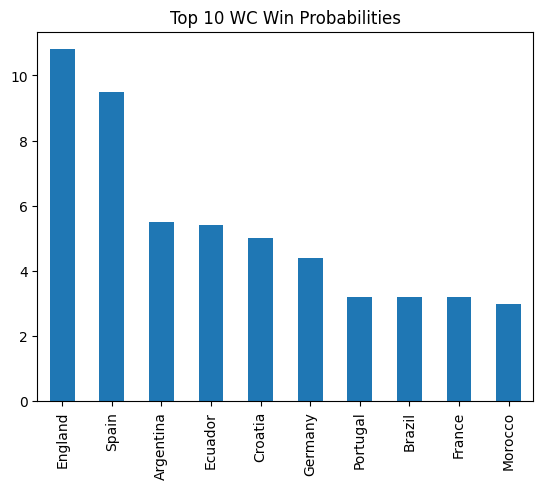

In [49]:
wc_probs['Win %'].head(10).plot(kind='bar', title='Top 10 WC Win Probabilities')


# Limitations & Future Work

* Squads and injuries not modeled

* Random WC 2026 groups (subject to update)

* No betting market calibration

* Attack/defense not separated (future work)